# Novak-Tyson Cell Cycle Model (1993)

_Kevin Siswandi_  
June 2020  

We are going to use the cell cycle model as a test problem for our empirical dynamic modeling method.

In cell cycle model, we have a multi-dimensional system with more than two species. Here, the system can exhibit both **stable oscillations and bistability**. Compare this with the 2-D Yeast Glycolysis model where we have either a stable fixed point or a stable oscillation.

![stable-oscillations](https://www.ncbi.nlm.nih.gov/pmc/articles/instance/1993813/bin/nihms16411f4a.jpg)

[Sible & Tyson (2007) Methods 41:238 - 247](https://pubmed.ncbi.nlm.nih.gov/17189866/). Simulations of the mathematical model of the cell cycle in frog egg extracts describe known and previously unobserved behaviors of the control system: Simulation of the changes in cyclin, preMPF and MPF levels over time in a cycling frog egg extract. The simulations are consistent with a body of experimental data.

<img src="https://www.ncbi.nlm.nih.gov/pmc/articles/instance/1993813/bin/nihms16411f5a.jpg" alt="drawing" width="400"/>

Theoretical predictions from Novak and Tyson: Hysteresis drives mitotic transitions in frog egg extracts. The simulation indicates that the concentration of cyclin required to drive high MPF activity (and thereby enter mitosis) is higher than the concentration required to maintain high MPF activity (and thereby stay in mitosis).

OBSERVE: **The MPF activity jumps down at a much lower level of cyclin than when it jumps up**.

## 1. Basics of the cell cycle

The species involved are:
- Maturation-promoting factor (MPF): a.k.a. mitosis-promoting factor or m-phase promoting factor. This is the activated MPF with one phosphate group removed from cdk1 (relative to pre-MPF).
- pre-MPF. Both activated MPF and pre-MPF consists of cdk-1 and cycB (cyclin).
- cdk1: cyclin-dependent kinase, also called cdc2
- cyclin: is alternately (cyclically) synthesized and degraded over time.
- wee1: opposes MPF activation.

G2 to M phase transition is driven by increase in MPF. One can regulate Cdk/MPF activity via either:
1. synthesis/degradation of cyclin
2. Phosphorylation/dephosphorylation of cdk

**Activation of MPF** by removing an inhibitory phosphate from the cdk subunit. MPF regulation involves positive feedback:
* One of the targets that cdk phosporylates is the protein cdc25, which is a phosphatase. Cdc25 becomes active when it gains a phosphate group.
* One of the targets of Cdc25 is pre-MPF.

Hence mutual activation: MPF activity increases cdc25 activity and vice versa, can lead to bistability.

**Deactivation of MPF** by putting an inhibitory phosphate to the cdk subunit. This occurs through the protein wee1. But MPF inhibits wee1.

![mpf-activation](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fnrc2169/MediaObjects/41568_2007_Article_BFnrc2169_Fig2_HTML.jpg)

[Boutros et al. (2007) Nat Rev Cancer 7, 495-507](https://www.nature.com/articles/nrc2169). a | Cell division cycle 25 (CDC25) phosphatases dephosphorylate and activate cyclin-dependent kinase (CDK)–cyclin complexes, thus allowing catalysis and substrate phosphorylation. WEE1 and MYT1 kinases phosphorylate CDK on tyrosine 15 and threonine 14 of CDK1. Phosphorylation by the CDK-activating kinase (CAK) is required for further activation of CDK–cyclin complexes. For simplicity, an orange P represents T14 and Y15 phosphorylation by WEE1 and MYT1, a blue P represents T161 phosphorylation by CAK. b | Although initial studies suggested a specific role for each CDC25 phosphatase at defined stages of the cell cycle, the current model is that CDC25A, B and C are all involved in phosphorylating CDK–cyclin complexes, such as CDK2–cyclin E at the G1–S transition or CDK1–cyclin B at the entry into mitosis. c | CDC25A, B and C control entry and progression into mitosis. CDC25B is thought to be responsible for the initial activation of CDK1–cyclin B at the centrosome that contributes to microtubule network reorganization and mitotic spindle assembly. Nuclear translocation leads to an auto-amplification process (bold arrows) of CDC25s that then fire the bulk of CDK1–cyclin B complexes and trigger mitosis.

**MPF triggers cyclin degradation**. when MPF activity increases, it activates (through Anaphase Promoting Complex or APC) cyclin protease which degrades cyclin. Thus, MPF positively regulates MPF destruction through APC.

The cell cycle is complex enough; it is almost impossible to make predictions using intuition.

## 2. Structure of the Novak-Tyson model

Main literature: [Novak & Tyson (1993), Journal of Cell Science 106:1153-1168](https://pubmed.ncbi.nlm.nih.gov/8126097/)

The model can be divided into two modules:
1. Cyclin/Cdk dimer regulation
2. Cyclin degradation regulation

Some notable parameters:
* [PPase] represents generic phosphatase activity
* $v_{22}$ for 'off' APC is much greater than $v_{21}$ for 'on' APC

**The Novak Tyson Model is implemented in the `source` directory**

In [1]:
from source import NovakTyson
import numpy as np

In [2]:
# testing if it works
# define default parameters        
NovakTyson.simulate_default(debug=True)

[1.0, 0.0, 0.0, 0.0, 0.0, -0.1485148514851485, -0.065]

In [3]:
# create dataset and plot
time_points, novak_data = NovakTyson.simulate_default()

import matplotlib.pyplot as plt

#plt.figure(figsize=(20, 10))

plt.plot(time_points, novak_data[0,:,0], 'g-', label = '[cyclin]')
plt.plot(time_points, novak_data[0,:,1], 'b-', label='[MPF]')
plt.xlabel('t')
plt.legend()
plt.title('Spontaneous oscillations of MPF and cyclin with control parameters')
plt.show()

Text(0.5, 1.0, 'Spontaneous oscillations of MPF and cyclin with control parameters')

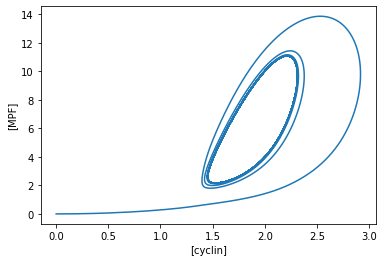

In [5]:
plt.plot(novak_data[0,:,0], novak_data[0,:,1])
plt.xlabel('[cyclin]')
plt.ylabel('[MPF]')
plt.show()

Some Results of the ODE model found by Novak and Tyson:

1. With the control parameters, the model predicts spontaneuous oscillations of MPF and cyclin. This can be interpreted as rapid cell divisions in newly fertilized oocyte -- consistent with experimental data.
2. Bistability between [Cyclin] total and [MPF] -- using non-degradable cyclin, this is consistent with experimental data.
3. [DNA] effects change the way MPF activity regulates wee1 and cdc25

<img src="image/threshold.png" alt="drawing" width="600"/>

Note that this results use non-degradable cyclin. Otherwise, with normal cyclin, MPF activity goes up, but MPF triggers the degradation of cyclin, so it will go down. The curves show sustained increase of cyclin only because the cyclin is non-degradable.

<img src="image/dna.png" alt="drawing" width="600"/>

Increasing amounts of unreplicated DNA shift the curves to the right. Therefore, unreplicated DNAs make it harder for MPF to inhibit wee1 or turn on cdc25. In other words, when [DNA] increases, there is more wee1 but less cdc25: more MPF in the pre- state.

In [6]:
# simulate data with custom parameters
# here we change the initial conditions of cyclin and MPF
time_points, novak_data = NovakTyson.simulate_custom(cyclin=22, MPF=11)

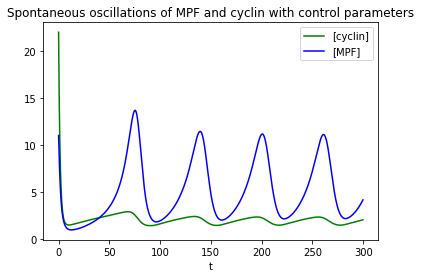

In [7]:
plt.plot(time_points, novak_data[0,:,0], 'g-', label = '[cyclin]')
plt.plot(time_points, novak_data[0,:,1], 'b-', label='[MPF]')
plt.xlabel('t')
plt.legend()
plt.title('Spontaneous oscillations of MPF and cyclin with control parameters')
plt.show()

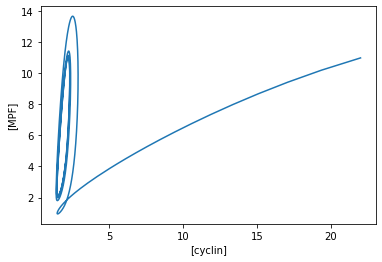

In [8]:
plt.plot(novak_data[0,:,0], novak_data[0,:,1])
plt.xlabel('[cyclin]')
plt.ylabel('[MPF]')
plt.show()